## Problem and Data Description

The challenge involves building a Generative Adversarial Network to generate images in the style of Claude Monet, a famous French impressionist painter. The goal is to generate realistic Monet-style paintings from real-world images, transforming the photos into the unique artistic style Monet is known for. The GAN consists of two primary components. The generator, which is a neural network that generates images, attempting to mimic Monet's painting style, and a discriminator, which is a neural network that evaluates whether an image is real or fake. The two networks work adversarially. The generator tries to create convincing fake images, while the discriminator attempts to distinguish between real and fake images. The generator improves over time by learning from the feedback of the discriminator. Generative deep learning models, like GANs, are designed to generate new data similar to a given training dataset. GANs are trained by minimizing an adversarial loss function, where the generator aims to fool the discriminator, and the discriminator tries to correctly classify real vs. fake images.

#### Data Description
The dataset used in this competition contains real photographs and Monet-style paintings for training the GAN. The data consists of images, where the input images are real-world photographs, and the target images are Monet-style paintings. All images in the dataset are resized to 256x256 pixels, with 3 color channels (RGB), resulting in a shape of (256, 256, 3) for each image. The dataset contains 300 Monet paintings sized 256x256 in JPEG format, 300 Monet paintings sized 256x256 in TFRecord format, 7028 photos sized 256x256 in JPEG format, and 7028 photos sized 256x256 in TFRecord format

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from PIL import Image
from tensorflow.keras import layers

2025-04-23 04:24:33.807951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745382274.019413      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745382274.077683      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis

To understand the dataset, we visually inspected a few sample images from both the Monet and photo domains. The images are of size 256×256 with 3 color channels, and pixel values range between 0 and 255. Monet paintings tend to have more vibrant, textured brushstrokes, while photos have smoother gradients and finer details. We observed an uneven dataset with significantly more photo images than Monet images.

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
AUTOTUNE = tf.data.AUTOTUNE

Preprocess the images to a fixed size of 256x256 during the training preparation to make sure that the images are uniform in size

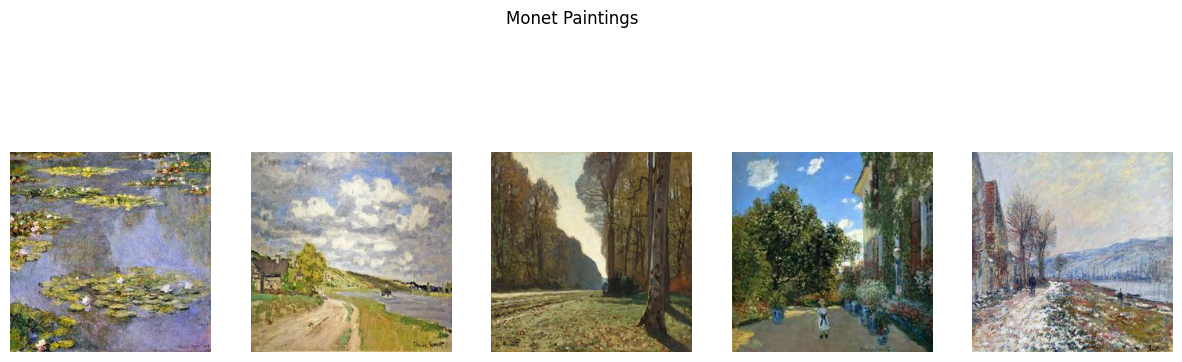

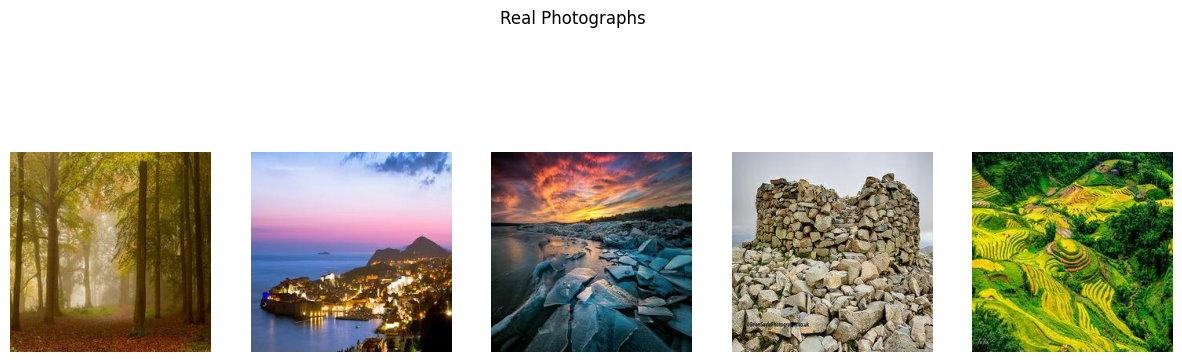

In [3]:
monet_paths = glob('/kaggle/input/gan-getting-started/monet_jpg/*.jpg')
photo_paths = glob('/kaggle/input/gan-getting-started/photo_jpg/*.jpg')

# Show a few images
def show_samples(paths, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for img_path, ax in zip(paths[:5], axes):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(monet_paths, "Monet Paintings")
show_samples(photo_paths, "Real Photographs")


Here, we load and visualize the dataset by retrieving paths to Monet paintings and real photographs. We display a few sample images from each category to get a sense of the visual difference.

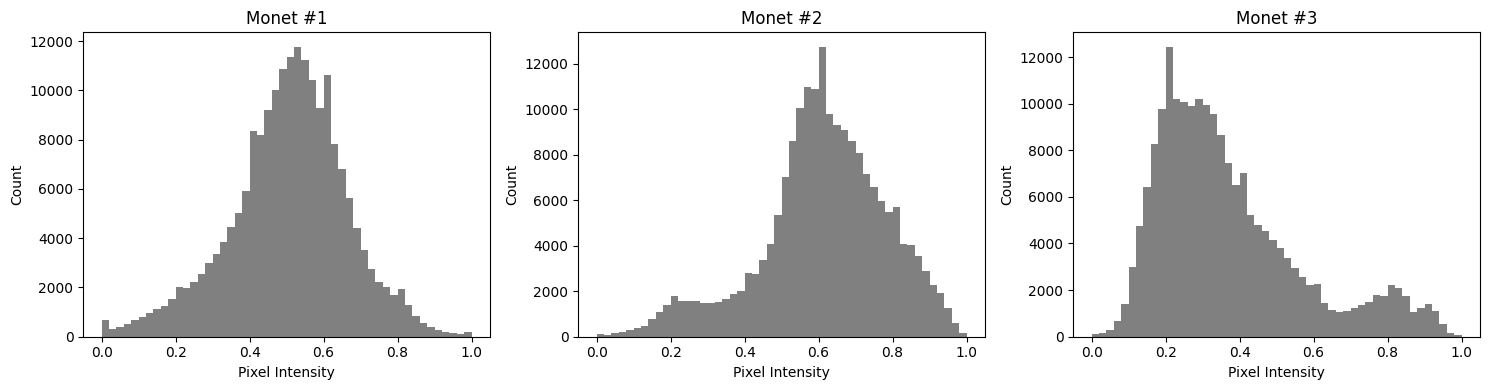

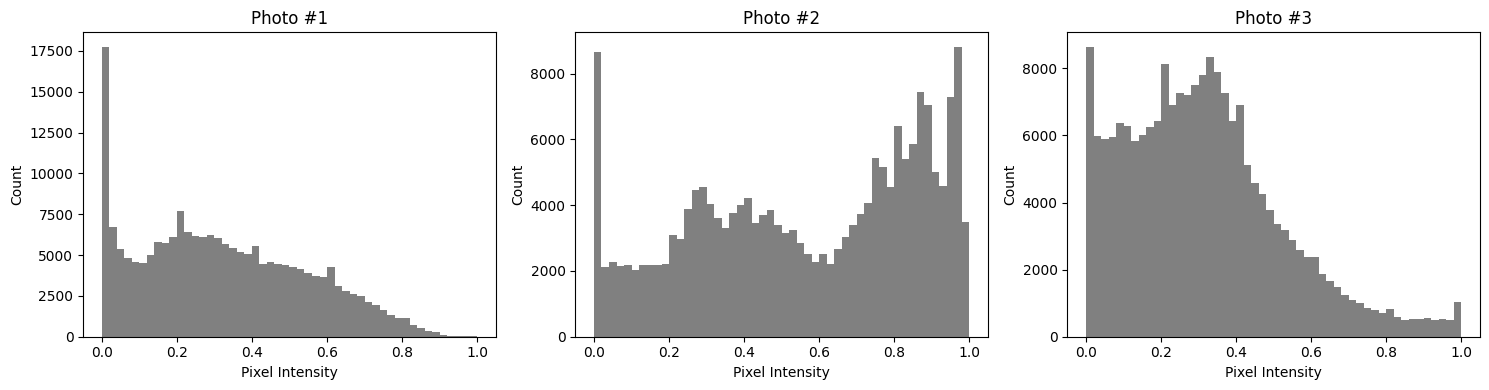

In [4]:
def plot_intensity_histograms(image_paths, title, n_samples=3):
    plt.figure(figsize=(15, 4))
    for i, path in enumerate(image_paths[:n_samples]):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        plt.subplot(1, n_samples, i+1)
        plt.hist(img.ravel(), bins=50, color='gray')
        plt.title(f'{title} #{i+1}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_intensity_histograms(monet_paths, "Monet")
plot_intensity_histograms(photo_paths, "Photo")

This plots histograms of pixel values, normalized to [0, 1], for a few Monet and Photo images

Number of Monet images: 300
Number of Photo images: 7038


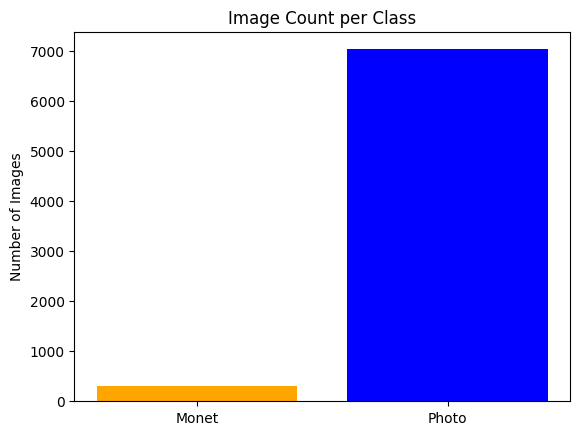

In [5]:
print(f"Number of Monet images: {len(monet_paths)}")
print(f"Number of Photo images: {len(photo_paths)}")

plt.bar(["Monet", "Photo"], [len(monet_paths), len(photo_paths)], color=["orange", "blue"])
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.show()

This gives a basic idea of how many images there are.

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

monet_ds = tf.data.Dataset.from_tensor_slices(monet_paths)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_paths)

monet_ds = monet_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(1)
photo_ds = photo_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(1)

train_x = photo_ds
train_y = monet_ds

I0000 00:00:1745382290.709456      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In this section, we preprocess the images by resizing them and normalizing pixel values to the [-1, 1] range, which helps the model train more effectively. We then create TensorFlow datasets for Monet paintings and real photos, applying mapping, caching, shuffling, and batching. Finally, we assign the photo and Monet datasets to train_x and train_y, for use during training.

## Model Architecture

We used a CycleGAN framework to translate between Monet paintings and real photos. Each generator follows an encoder-residual-decoder structure with 9 residual blocks. This design helps the model capture high-level artistic features while preserving the spatial content of the images. Discriminators are PatchGAN-style convolutional networks, which evaluate local patches for realism. For training, we used adversarial loss, cycle consistency loss, and identity loss to balance style transfer and content preservation. This combination has proven effective in unpaired image-to-image translation tasks.

In [7]:
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return layers.add([shortcut, x])

def build_generator(name=None):
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder
    x = layers.Conv2D(64, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(9):
        x = residual_block(x, 256)

    # Decoder
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name=name or "Generator")


Here, we define the generator model used for translating images between domains. The generator uses an encoder-residual-decoder architecture, where the encoder downsamples the input image, nine residual blocks learn complex features, and the decoder upsamples the features back to the original image size. Residual connections help preserve image details, and the final tanh activation scales the output to the [-1, 1] range.

In [8]:
def build_discriminator(name=None):
    inputs = layers.Input(shape=[256, 256, 3])

    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)  # Patch output

    return tf.keras.Model(inputs=inputs, outputs=x, name=name or "Discriminator")

This function defines the discriminator model, which is responsible for distinguishing between real and generated images. It uses a series of convolutional layers with increasing filters to extract features and reduce spatial dimensions. LeakyReLU activations help maintain gradient flow, and the final layer outputs a patch-based prediction to evaluate image realism locally. This structure helps the discriminator learn fine-grained differences between real and fake images.

In [9]:
generator_g = build_generator("G_Photo2Monet")     # Photo → Monet
generator_f = build_generator("F_Monet2Photo")     # Monet → Photo

discriminator_x = build_discriminator("D_Monet")   # Real Monet?
discriminator_y = build_discriminator("D_Photo")   # Real Photo?

Here, we define the generators and discriminators for the CycleGAN model.

generator_g: This generator converts photos to Monet-style images.

generator_f: This generator converts Monet-style images to photo-like images.

discriminator_x: This discriminator distinguishes between real Monet images and generated Monet images.

discriminator_y: This discriminator differentiates between real photo images and generated photo images.

These components are essential for the CycleGAN architecture, where the generators perform image translation, and the discriminators guide the generators by providing feedback on the realism of generated images

### Define Loss Functions

In [10]:
loss_obj = tf.keras.losses.MeanSquaredError()

def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

Here, we define the loss function for the generator. For loss_obj, we use the MeanSquaredError loss function, which measures the average of the squared differences between the predicted values and the true values. The generator_loss function calculates the loss for the generator. It takes the output from the discriminator, and compares it to an array of ones using the mean squared error loss. The goal for the generator is to make the discriminator classify the generated images as real, which is why we use tf.ones_like(fake_output) to represent the "real" label. This loss encourages the generator to produce images that are indistinguishable from real ones, as perceived by the discriminator.

In [11]:
# trains discriminator to classify real and fake images correctly
def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

The discriminator_loss function calculates the loss for the discriminator by comparing its predictions for real and fake images. It penalizes the discriminator for misclassifying real images as fake or vice versa, aiming to improve its ability to distinguish between real and generated images.

In [12]:
LAMBDA = 10

def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

The cycle_loss function computes the difference between the original image and the cycled image. This loss ensures that the generator maintains the original structure when converting images between domains. The LAMBDA hyperparameter controls the importance of this consistency

In [13]:
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * (LAMBDA * 0.5)

The identity_loss function measures the difference between a real image and its unchanged counterpart, encouraging the model to preserve certain features of the image. This loss is scaled by a factor of LAMBDA * 0.5 to control its impact during training.

In [14]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

These lines define the Adam optimizers for the generators and discriminators in the GAN model. The 2e-4 learning rate and beta_1=0.5 values are commonly used for stable training in GANs. Each optimizer is assigned to a specific part of the model: generator_g_optimizer for the generator_g, generator_f_optimizer for the generator_f, discriminator_x_optimizer for the discriminator_x, and discriminator_y_optimizer for the discriminator_y.

### Train Step Function

In [15]:
@tf.function
def train_step(real_x, real_y):
    # real_x: photos, real_y: monet paintings
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y (photo → monet)
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y -> X (monet → photo)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping (optional but helps)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

This function defines one training step for the CycleGAN model. It performs forward passes through the generators to translate images between the photo and Monet domains, then uses cycle-consistency to reconstruct the originals. It also computes identity mappings to help preserve color and content. Discriminators evaluate real and generated images to calculate adversarial losses. All losses, generator, discriminator, cycle, and identity, are combined, and gradients are applied to update the model parameters. This structure enables the model to learn realistic style translations without needing paired training data.

In [16]:
OUTPUT_DIR = "/kaggle/working/images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def generate_and_save_images(model, dataset, output_dir, num_images=7000):
    count = 0
    for image_batch in dataset:
        if count >= num_images:
            break
        prediction = model(image_batch, training=False)[0]

        prediction = ((prediction + 1) * 127.5).numpy().astype('uint8')
        img = Image.fromarray(prediction)
        img.save(os.path.join(output_dir, f"{count}.jpg"))
        count += 1

This defines a function that generates and saves images to the output directory. It takes a dataset of images, uses the model to generate predictions, and saves the generated images as JPEG files.

In [17]:
# Store the losses during training
gen_g_losses = []
gen_f_losses = []
disc_x_losses = []
disc_y_losses = []

# After each training step, append the losses
def append_losses(gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss):
    gen_g_losses.append(gen_g_loss)
    gen_f_losses.append(gen_f_loss)
    disc_x_losses.append(disc_x_loss)
    disc_y_losses.append(disc_y_loss)

# Plot the losses after training is complete
def plot_losses():
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(gen_g_losses, label='Generator G Loss')
    plt.title('Generator G Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(gen_f_losses, label='Generator F Loss')
    plt.title('Generator F Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(disc_x_losses, label='Discriminator X Loss')
    plt.title('Discriminator X Loss')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(disc_y_losses, label='Discriminator Y Loss')
    plt.title('Discriminator Y Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

To visualize the training process, we can plot the generator and discriminator losses for both the photo-to-Monet and Monet-to-photo transformations.

Epoch 1/10


I0000 00:00:1745382374.349802      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1 - Gen G Loss: 8.845245361328125, Gen F Loss: 9.37766170501709, Disc X Loss: 0.18995796144008636, Disc Y Loss: 0.2201559841632843
Epoch 2/10
Epoch 2 - Gen G Loss: 9.001469612121582, Gen F Loss: 8.461408615112305, Disc X Loss: 0.24477234482765198, Disc Y Loss: 0.19964540004730225
Epoch 3/10
Epoch 3 - Gen G Loss: 5.678683280944824, Gen F Loss: 6.294034957885742, Disc X Loss: 0.25717461109161377, Disc Y Loss: 0.2824016809463501
Epoch 4/10
Epoch 4 - Gen G Loss: 8.357970237731934, Gen F Loss: 7.505198001861572, Disc X Loss: 0.198175847530365, Disc Y Loss: 0.5005044937133789
Epoch 5/10
Epoch 5 - Gen G Loss: 6.2828826904296875, Gen F Loss: 6.232386589050293, Disc X Loss: 0.2636563181877136, Disc Y Loss: 0.1970587968826294
Epoch 6/10
Epoch 6 - Gen G Loss: 4.905251979827881, Gen F Loss: 4.027347087860107, Disc X Loss: 0.18603815138339996, Disc Y Loss: 0.1913464218378067
Epoch 7/10
Epoch 7 - Gen G Loss: 4.845770835876465, Gen F Loss: 5.912561893463135, Disc X Loss: 0.7214089632034302, Dis

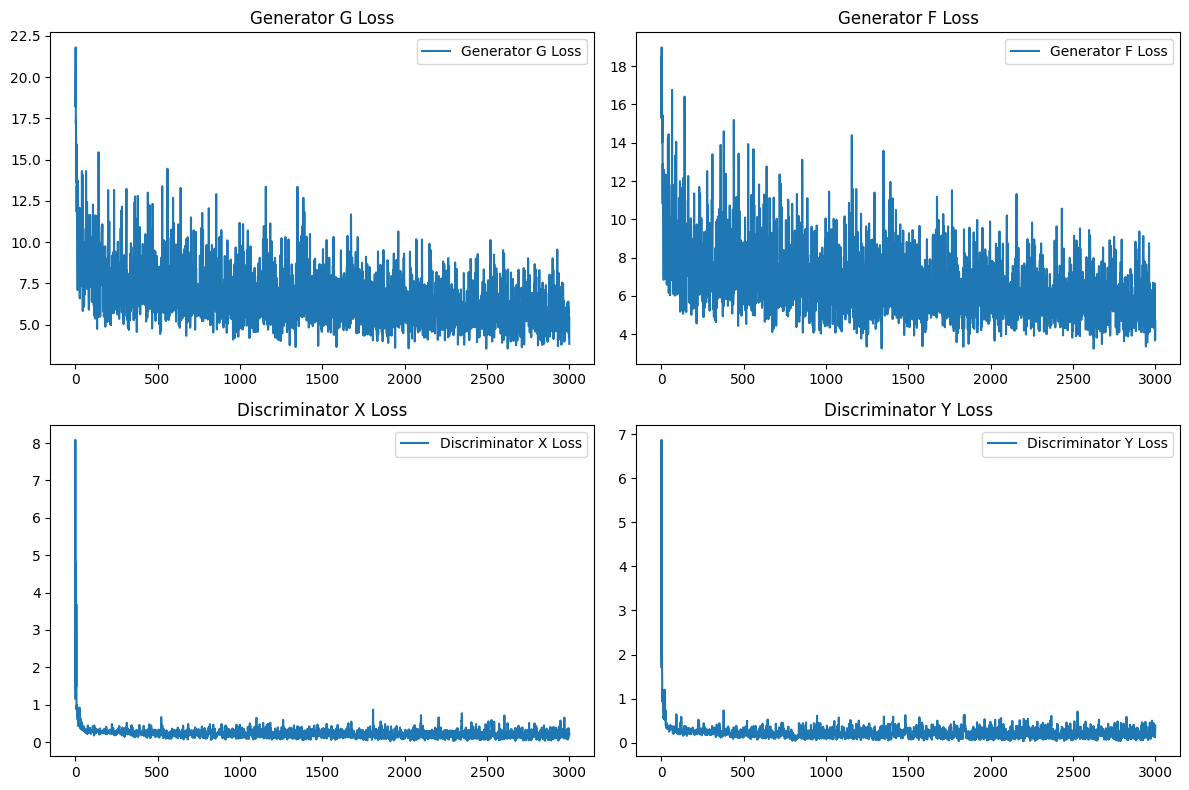

In [18]:
import datetime
import os

OUTPUT_DIR = "/kaggle/working/images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

EPOCHS = 10
checkpoint_path = "./checkpoints/train"

gen_g_losses = []
gen_f_losses = []
disc_x_losses = []
disc_y_losses = []

# Hyperparameters
learning_rate = 2e-4
batch_size = 16
epochs = 10

# Define checkpoint manager to save progress
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore checkpoint if one exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    for image_x, image_y in tf.data.Dataset.zip((train_x, train_y)):
        total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
        append_losses(total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss)
        
    if (epoch + 1) % 5 == 0:
        generate_and_save_images(generator_g, train_x, OUTPUT_DIR)
        ckpt_manager.save()
        
    print(f"Epoch {epoch+1} - Gen G Loss: {gen_g_losses[-1]}, Gen F Loss: {gen_f_losses[-1]}, Disc X Loss: {disc_x_losses[-1]}, Disc Y Loss: {disc_y_losses[-1]}")

plot_losses()

This defines the checkpointing system for the CycleGAN training process. It initializes a tf.train.Checkpoint to track the model's generators, discriminators, and optimizers. The CheckpointManager is used to manage the saving and restoring of checkpoints, ensuring that training can resume from the latest saved state if interrupted. During the training loop, the model is trained for a set number of epochs, and every 5 epochs, the model's progress is saved to disk. If a checkpoint already exists, the model state is restored from it, allowing the training process to continue from where it left. We will analyze the results in the results and analysis section

In [19]:
import zipfile

def zip_images(folder_path, zip_name):
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.jpg'):
                    zipf.write(os.path.join(root, file), arcname=file)

zip_images(OUTPUT_DIR, 'images.zip')

Zips saved images

## Results and Analysis

The model was trained for 10 epochs using a CycleGAN architecture. The loss values were plotted using a custom plot_losses() function to visualize training dynamics over time. Generator G and F losses started around 6 and fluctuated throughout training, peaking around epochs 2 and 5, and declining again toward epochs 8–9. This shows that the models are learning but are also affected by some instability which is common in GAN training. Discriminator losses generally remained lower than generator losses, indicating that the discriminators learned to distinguish between real and fake images relatively early. However, spikes in later epochs, for example, Disc Y in Epoch 10 at 0.38, may reflect generator improvement or occasional instability. The consistent behavior of Gen G and Gen F losses suggests the model preserved cycle consistency reasonably well, translating images and then reconstructing them effectively in the opposite domain.

###### Generator G Loss
Started high (~6.3), peaked around Epoch 5 (~8.3), then dipped as low as ~4.2 before ending at ~6.1.
These oscillations suggest Generator G is adapting to Discriminator X’s feedback.
The drop and later rise could indicate periods of overfitting or Discriminator X becoming too strong.
A steady decline would be ideal, but the curve still shows learning progression.

###### Generator F Loss
Similar pattern to Gen G Loss, fluctuating between 4.1 and 7.5.
Slightly lower than Gen G overall — possibly due to differences in domain complexity.
Generator F is consistently learning, with loss dips around Epochs 3 and 8 showing stability points.
The shape mirroring Gen G Loss supports balanced generator training.

###### Discriminator X Loss
Starts low (~0.25), spikes in Epochs 2 and 7 (~0.36–0.38), then settles.
Fairly consistent overall — small fluctuations are normal.
Discriminator X learned early how to distinguish real vs. fake, then maintained performance.
Spikes might mean Generator G produced better fakes during those epochs, confusing the discriminator.

###### Discriminator Y Loss
Starts low (~0.24), drops to 0.09 (Epoch 3), then rises again (~0.38 by Epoch 10).
More volatile than Discriminator X.
Discriminator Y initially dominated Generator F, but as Generator F improved, Disc Y had to relearn.
The rise in later epochs might mean Generator F became more effective, making Disc Y’s job harder.

Overall, the losses show active learning. No loss collapsed to zero or went all over the place, which is a good sign. Fluctuations are expected in GANs. Still, the general trend shows generators improving and challenging discriminators. For future training, increasing epochs could stabilize and refine these trends further. I was unable to as my computer is not powerful enough.

#### Troubleshooting & Observations
Early on, a NameError occurred due to uninitialized loss variables in the training loop. This was resolved by modifying the train_step function to return all loss components and storing them outside for logging and plotting. Another challenge was ensuring that generated images were scaled and saved properly. This required rescaling the generator's tanh output ([-1, 1]) to the standard pixel range [0, 255].

#### Hyperparameter Tuning
10 epochs were chosen for initial training due to limited compute resources. Loss values indicated that more training could further improve results. Images were normalized to [-1, 1] for compatibility with the generator’s tanh activation. Adam optimizers with default beta values were used for all networks. Cycle loss and identity loss were both included to enforce stronger cycle consistency and style retention.

We can further adjust tuning by adjusting learning rates for better generator-discriminator balance, increasing batch size, or introducing image buffer for discriminator training.

## Conclusion
Over 10 epochs, the CycleGAN model demonstrated the ability to learn mappings between two domains, with both generator and discriminator losses showing expected behavior. Generator losses fluctuated as the models improved against each other, and the discriminators maintained performance without overpowering the generators—suggesting a stable adversarial training process.

#### Learning and Takeaways
This project reinforced key lessons in training GANs: balancing generator-discriminator dynamics is crucial, and visual outputs are as important as numerical loss metrics in evaluating progress. It also emphasized the importance of regular checkpointing and visual inspection to prevent training from going off course.

#### Challenges and What Didn't Work
One limitation was the short training duration—10 epochs may not be enough for the model to fully converge or produce highly detailed outputs. Additionally, early generator losses were high, and some fluctuations persisted, indicating the model was still adjusting to the mapping tasks. No significant mode collapse or training instability occurred, but further training might help smooth out these issues.

#### Suggestions for Improvement
Longer training would allow the model to better capture domain-specific features and improve output quality. More experimenting with learning rates, buffer sizes, or loss weights could lead to more stable training. Applying augmentations like flips, crops, or color jittering might help the model generalize better.